<a href="https://colab.research.google.com/github/dinesh0002/HackSlash_Competition-/blob/main/cycle_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==1.2
!pip install -q git+https://github.com/tensorflow/examples.git
!ls

sample_data


In [ ]:
# importing libraries 

import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
import scipy.ndimage.interpolation
from tensorflow.examples.tutorials.mnist import input_data


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:461: FutureWarning: Passing (type, 1) or 

In [ ]:
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2141754287862283690]

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

--2021-02-21 05:14:07--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.47.86
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.47.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  14.8MB/s    in 1.7s    

2021-02-21 05:14:09 (14.8 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2021-02-21 05:14:09--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.47.86
Connecting to fashion-mnist.s3-website.eu-central-1.amazona

In [ ]:
!ls

sample_data		   train-images-idx3-ubyte.gz
t10k-images-idx3-ubyte.gz  train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte.gz


In [ ]:
# TRAINING PARAMETERS

learning_rate = 0.0002
batch_size = 32
epochs = 100000

# NETWORK PARAMETERS

image_dimension = 784 # size of the image is 28x28 px

#Discriminator Nodes
H_dim = 128

# INITILIZATION FUNCTION 

def xavier_init(shape):
  return tf.random_normal(shape = shape, stddev= 1./tf.sqrt(shape[0]/2.0))

In [ ]:
# placeholders for external input

X_A = tf.placeholder(tf.float32, shape = [None, image_dimension])
X_B = tf.placeholder(tf.float32, shape = [None, image_dimension])

In [ ]:
tf.__version__

'1.2.0'

In [ ]:
# Define weights and biases for dictionaries for Discriminator A

Disc_A_W = { "disc_H" : tf.Variable(xavier_init([image_dimension, H_dim])),
             "disc_final": tf.Variable(xavier_init([H_dim, 1]))}

Disc_A_Bias = { "disc_H" : tf.Variable(xavier_init([H_dim])),
             "disc_final": tf.Variable(xavier_init([1]))}


# Define weights and biases for dictionaries for Discriminator B

Disc_B_W = { "disc_H" : tf.Variable(xavier_init([image_dimension, H_dim])),
             "disc_final": tf.Variable(xavier_init([H_dim, 1]))}

Disc_B_Bias = { "disc_H" : tf.Variable(xavier_init([H_dim])),
             "disc_final": tf.Variable(xavier_init([1]))}

# Define weights and biases for dictionaries for Generator transforming A to B

Gen_AB_W = { "Gen_H" : tf.Variable(xavier_init([image_dimension, H_dim])),
             "Gen_final": tf.Variable(xavier_init([H_dim, image_dimension]))} 
Gen_AB_Bias = { "Gen_H" : tf.Variable(xavier_init([H_dim])),
             "Gen_final": tf.Variable(xavier_init([image_dimension]))}


# Define weights and biases for dictionaries for Generator transforming B to A

Gen_BA_W = { "Gen_H" : tf.Variable(xavier_init([image_dimension, H_dim])),
             "Gen_final": tf.Variable(xavier_init([H_dim, image_dimension]))}

Gen_BA_Bias = { "Gen_H" : tf.Variable(xavier_init([H_dim])),
             "Gen_final": tf.Variable(xavier_init([image_dimension]))}

In [ ]:
def Disc_A(x):
  D_hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, Disc_A_W["disc_H"]), Disc_A_Bias["disc_H"]))
  disc_output = (tf.add(tf.matmul(D_hidden_layer, Disc_A_W["disc_final"]), Disc_A_Bias["disc_final"]))
  disc_prob_output = tf.nn.sigmoid(disc_output)
  return disc_prob_output

def Disc_B(x):
  D_hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, Disc_B_W["disc_H"]), Disc_B_Bias["disc_H"]))
  disc_output = (tf.add(tf.matmul(D_hidden_layer, Disc_B_W["disc_final"]), Disc_B_Bias["disc_final"]))
  disc_prob_output = tf.nn.sigmoid(disc_output)
  return disc_prob_output

In [ ]:
# Generator Neural Network

def GenAB(x):
  G_hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, Gen_AB_W["Gen_H"]), Gen_AB_Bias["Gen_H"]))
  Gen_output = (tf.add(tf.matmul(G_hidden_layer, Gen_AB_W["Gen_final"]), Gen_AB_Bias["Gen_final"]))
  Gen_prob_output = tf.nn.sigmoid(Gen_output)
  return Gen_prob_output

def GenBA(x):
  G_hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, Gen_BA_W["Gen_H"]), Gen_BA_Bias["Gen_H"]))
  Gen_output = (tf.add(tf.matmul(G_hidden_layer, Gen_BA_W["Gen_final"]), Gen_BA_Bias["Gen_final"]))
  Gen_prob_output = tf.nn.sigmoid(Gen_output)
  return Gen_prob_output

In [ ]:
# CYCLE GAN NETWORK


# GAN for approximating B Distribution

X_BA = GenBA(X_B)
Disc_A_real = Disc_A(X_A)
Disc_A_fake = Disc_A(X_BA)

# GAN for approximating B Distribution

X_AB = GenBA(X_A)
Disc_B_real = Disc_A(X_B)
Disc_B_fake = Disc_A(X_AB)

In [ ]:
# Discriminator Loss Functions

Loss_Disc_A = (tf.reduce_mean(tf.square(Disc_A_real - tf.ones_like(Disc_A_real)) + tf.reduce_mean(tf.square(Disc_A_fake))))/2
Loss_Disc_B = (tf.reduce_mean(tf.square(Disc_B_real - tf.ones_like(Disc_B_real)) + tf.reduce_mean(tf.square(Disc_B_fake))))/2

Disc_Loss = Loss_Disc_A + Loss_Disc_B

In [ ]:
# image reconstruction

X_BAB = GenAB(X_BA)
X_ABA = GenBA(X_AB)

In [ ]:
# Generator Loss function

Loss_Gen_A = tf.reduce_mean(tf.square(Disc_B_fake - tf.ones_like(Disc_B_fake)))
Loss_Gen_B = tf.reduce_mean(tf.square(Disc_A_fake - tf.ones_like(Disc_A_fake)))
Loss_total = Loss_Gen_A + Loss_Gen_B

# Reconstruction Loss

Loss_recon_A = tf.reduce_mean(10*tf.abs((X_A-X_ABA)))
Loss_recon_B = tf.reduce_mean(10*tf.abs((X_B-X_BAB)))
Loss_recon_total = Loss_recon_A +Loss_recon_B

Gen_Loss = Loss_total + Loss_recon_total

In [ ]:
# parameters list of Discriminator
Disc_param = [Disc_A_W['disc_H'], Disc_A_W["disc_final"], Disc_A_Bias['disc_H'], Disc_A_Bias['disc_final'],
              Disc_B_W['disc_H'], Disc_B_W['disc_final'],Disc_B_Bias['disc_H'], Disc_B_Bias['disc_final'] ]

# parameters list of Gen
Gen_param = [Gen_AB_W['Gen_H'], Gen_AB_W["Gen_final"], Gen_AB_Bias['Gen_H'], Gen_AB_Bias['Gen_final'],
            Gen_BA_W['Gen_H'], Gen_BA_W['Gen_final'],Gen_BA_Bias['Gen_H'], Gen_BA_Bias['Gen_final'] ]


# Defining the optimizer
Gen_Optimize = tf.train.AdadeltaOptimizer(learning_rate=learning_rate).minimize(Gen_Loss, var_list = Gen_param)
Disc_Optimize = tf.train.AdadeltaOptimizer(learning_rate=learning_rate).minimize(Disc_Loss, var_list = Disc_param)

In [ ]:
# DATASET PREPARATION

!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz


!mkdir MNIST_Fashion
!cp *.gz MNIST_Fashion/

# import input_data
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_Fashion/")

# Assembling the training data from two domains

X_train = mnist.train.images
mid = int(X_train.shape[0]/2)

# Real Images Dataset 1
X_train_real = X_train[:mid]

# Rotated images Dataset 2
X_train_rot = X_train[mid:].reshape(-1,28,28)
X_train_rot = scipy.ndimage.interpolation.rotate(X_train_rot, 90, axes = (1,2))
X_train_rot = X_train_rot.reshape(-1,28*28)

# random shuffling

def shuffle_data(x, size):
  start_index = np.random.randint(0, x.shape[0]-size)
  return x[start_index:start_index + size]

--2021-02-21 06:39:09--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.94
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.72.94|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz.1’

train-images-idx3-u 100%[===================>]  25.20M  14.6MB/s    in 1.7s    

2021-02-21 06:39:11 (14.6 MB/s) - ‘train-images-idx3-ubyte.gz.1’ saved [26421880/26421880]

--2021-02-21 06:39:11--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.94
Connecting to fashion-mnist.s3-website.eu-central-1.ama

In [ ]:
# Initialize the variables

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

for epoch in range(epochs):
  X_A_batch = shuffle_data(X_train_real, batch_size)
  X_B_batch = shuffle_data(X_train_rot, batch_size)

  _, Disc_loss_epoch = sess.run([Disc_Optimize, Disc_Loss], feed_dict = {X_A:X_A_batch, X_B:X_B_batch})
  _, Gen_loss_epoch = sess.run([Gen_Optimize, Gen_Loss], feed_dict = {X_A:X_A_batch, X_B:X_B_batch})

  if epoch % 2000 == 0:
    print("steps: {0}, Disc loss; {1}, Gen Loss: {2}".format(epoch, Disc_loss_epoch, Gen_loss_epoch))

steps: 0, Disc loss; 0.5274966359138489, Gen Loss: 8.155418395996094
steps: 2000, Disc loss; 0.45221197605133057, Gen Loss: 8.358421325683594
steps: 4000, Disc loss; 0.3998652994632721, Gen Loss: 8.370229721069336
steps: 6000, Disc loss; 0.3482336103916168, Gen Loss: 8.494539260864258
steps: 8000, Disc loss; 0.2908690571784973, Gen Loss: 8.623481750488281
steps: 10000, Disc loss; 0.26966309547424316, Gen Loss: 8.499046325683594
steps: 12000, Disc loss; 0.25076112151145935, Gen Loss: 8.435574531555176
steps: 14000, Disc loss; 0.2338753193616867, Gen Loss: 8.298563003540039
steps: 16000, Disc loss; 0.19764095544815063, Gen Loss: 8.421874046325684
steps: 18000, Disc loss; 0.19812703132629395, Gen Loss: 8.368968963623047
steps: 20000, Disc loss; 0.20944970846176147, Gen Loss: 8.180951118469238
steps: 22000, Disc loss; 0.2580937147140503, Gen Loss: 8.09900188446045
steps: 24000, Disc loss; 0.24139097332954407, Gen Loss: 7.907842636108398
steps: 26000, Disc loss; 0.2221590280532837, Gen Loss

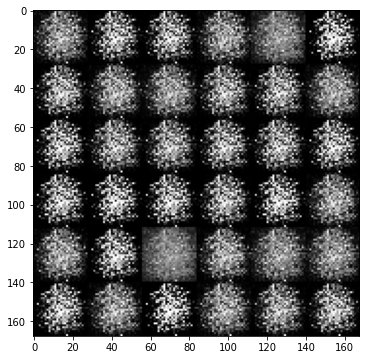

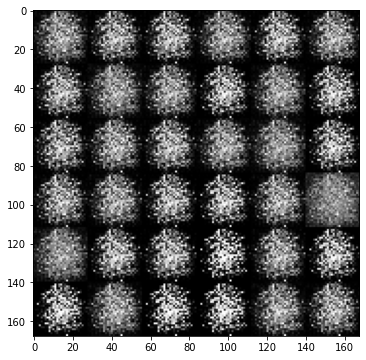

In [20]:
# Testing

n = 6
canvas1 = np.empty((28*n, 28*n))
canvas2 = np.empty((28*n, 28*n))

for i in range(n):
  test_A = shuffle_data(X_train_real, batch_size)
  test_B = shuffle_data(X_train_rot, batch_size)

  # Generate A images from B
  out_A = sess.run(X_BA, feed_dict={X_B: test_B})

  # Generate B images from A
  out_B = sess.run(X_AB, feed_dict={X_A: test_A})
  
  for j in range(n):
    # Draw the Generated Digits
    canvas1[i*28: (i + 1) *28, j* 28:(j+1) *28] = out_A[j].reshape([28,28])

  for j in range(n):
    # Draw the Generated Digits
    canvas2[i*28: (i + 1) *28, j* 28:(j+1) *28] = out_B[j].reshape([28,28])

# One way of displaying
plt.figure(figsize=(n, n))
plt.imshow(canvas1, origin = "upper", cmap = "gray")
plt.show()

plt.figure(figsize = (n,n))
plt.imshow(canvas2, origin="upper", cmap="gray")
plt.show()